In [37]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [38]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [39]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [40]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [41]:
tf.keras.backend.clear_session()

In [42]:
subject = 'Tocantins - Consumo de Cimento (t)'
start_index = 0
split_index = 191 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 30

In [43]:
data = pd.read_csv('2003_mo_model_input_TO.csv')
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data =data.drop([' NFSP - Fluxo Mensal (Milhões de reais)'], axis=1)
data

,Unnamed: 0,IPCA - Variação mensal durante o Plano Real (%),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Tocantins - Desemprego,Precipitation (mm/day),...,Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Tocantins - PIB - Estadual,Tocantins - PIB - Construção Civil,Tocantins - PIB - Per Capita,Tocantins - PIB - Preços de Mercado,Tocantins - Produção de Cimento (t),Tocantins - IDH,Tocantins - Consumo de Cimento (t)
0,2003-1,0.724032,11.520143,1.611498,1.036534,1.772069e+08,7.330309e+06,0.969649,8.243830,3.576410,...,18.470168,64.274735,1.922279,1.593908e+07,1.457380e+06,10.276585,2.572692e+07,12.733000,0.700107,17.555
1,2003-2,0.690297,11.189862,1.450389,0.993449,1.773884e+08,7.335910e+06,0.950783,8.237931,3.573972,...,18.468827,64.266609,1.922184,1.596108e+07,1.459029e+06,10.281590,2.576177e+07,12.733000,0.700487,14.976
2,2003-3,0.669681,10.820792,1.870184,0.973020,1.775699e+08,7.341511e+06,0.938332,8.232033,3.572551,...,18.468045,64.261870,1.922064,1.598308e+07,1.460678e+06,10.286595,2.579662e+07,12.733000,0.700866,13.334
3,2003-4,0.660494,10.417840,1.355287,0.940489,1.777514e+08,7.347112e+06,0.926401,8.226135,3.572398,...,18.467962,64.261362,1.921914,1.600508e+07,1.462328e+06,10.291600,2.583147e+07,12.733000,0.701246,15.173
4,2003-5,0.648337,9.959690,1.585538,0.917493,1.779329e+08,7.352713e+06,0.951683,8.220236,3.576238,...,18.686479,65.145668,1.897554,1.602709e+07,1.463977e+06,10.296605,2.586632e+07,12.733000,0.701626,18.728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.396851,...,15.635298,49.617111,1.526117,NaN,NaN,NaN,NaN,67.097178,NaN,54.154
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.410845,...,17.035263,55.475580,1.386414,NaN,NaN,NaN,NaN,67.077411,NaN,55.664
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.486447,...,17.968985,59.515759,1.338741,NaN,NaN,NaN,NaN,66.563807,NaN,52.320
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.707722,...,18.616615,63.372779,1.347667,NaN,NaN,NaN,NaN,65.682099,NaN,43.036


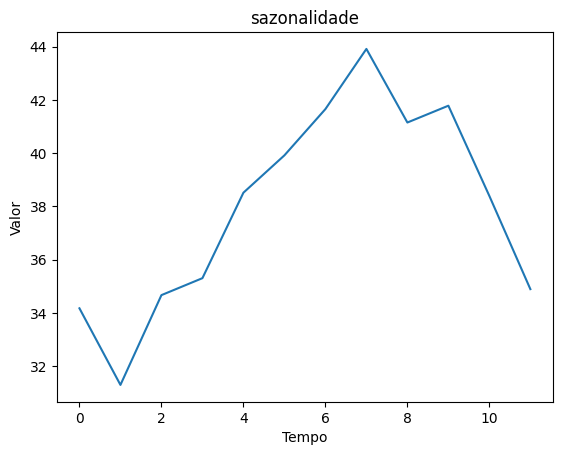

,sazonalidade
sazonalidade,
0,34.175036
1,31.298071
2,34.670393
3,35.307286
4,38.517000
5,39.919429
6,41.656769
7,43.916308
8,41.152538


In [44]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [45]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,IPCA - Variação mensal durante o Plano Real (%),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Tocantins - Desemprego,Precipitation (mm/day),...,Air Relative Humidity (%),Wind Gust (m/s),Tocantins - PIB - Estadual,Tocantins - PIB - Construção Civil,Tocantins - PIB - Per Capita,Tocantins - PIB - Preços de Mercado,Tocantins - Produção de Cimento (t),Tocantins - IDH,sazonalidade,Tocantins - Consumo de Cimento (t)
0,2003-1,0.724032,11.520143,1.611498,1.036534,1.772069e+08,7.330309e+06,0.969649,8.243830,3.576410,...,64.274735,1.922279,1.593908e+07,1.457380e+06,10.276585,2.572692e+07,12.733000,0.700107,34.175036,17.555
1,2003-2,0.690297,11.189862,1.450389,0.993449,1.773884e+08,7.335910e+06,0.950783,8.237931,3.573972,...,64.266609,1.922184,1.596108e+07,1.459029e+06,10.281590,2.576177e+07,12.733000,0.700487,31.298071,14.976
2,2003-3,0.669681,10.820792,1.870184,0.973020,1.775699e+08,7.341511e+06,0.938332,8.232033,3.572551,...,64.261870,1.922064,1.598308e+07,1.460678e+06,10.286595,2.579662e+07,12.733000,0.700866,34.670393,13.334
3,2003-4,0.660494,10.417840,1.355287,0.940489,1.777514e+08,7.347112e+06,0.926401,8.226135,3.572398,...,64.261362,1.921914,1.600508e+07,1.462328e+06,10.291600,2.583147e+07,12.733000,0.701246,35.307286,15.173
4,2003-5,0.648337,9.959690,1.585538,0.917493,1.779329e+08,7.352713e+06,0.951683,8.220236,3.576238,...,65.145668,1.897554,1.602709e+07,1.463977e+06,10.296605,2.586632e+07,12.733000,0.701626,38.517000,18.728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.396851,...,49.617111,1.526117,NaN,NaN,NaN,NaN,67.097178,NaN,43.916308,54.154
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.410845,...,55.475580,1.386414,NaN,NaN,NaN,NaN,67.077411,NaN,41.152538,55.664
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.486447,...,59.515759,1.338741,NaN,NaN,NaN,NaN,66.563807,NaN,41.783923,52.320
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.707722,...,63.372779,1.347667,NaN,NaN,NaN,NaN,65.682099,NaN,38.394077,43.036


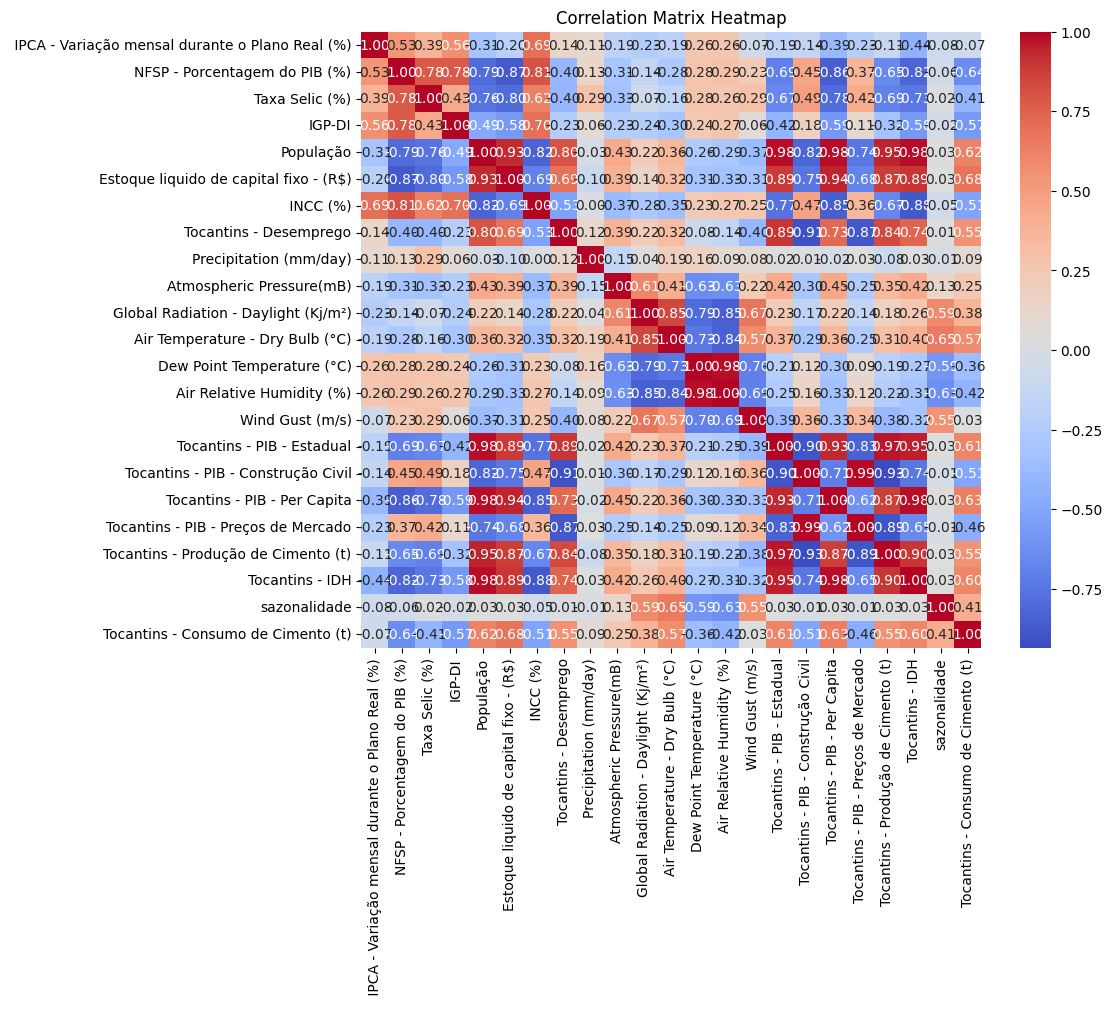

In [46]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [47]:
data =data.drop(['Precipitation (mm/day)',
                 'Wind Gust (m/s)'], axis=1)
data

,Unnamed: 0,IPCA - Variação mensal durante o Plano Real (%),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Tocantins - Desemprego,Atmospheric Pressure(mB),...,Dew Point Temperature (°C),Air Relative Humidity (%),Tocantins - PIB - Estadual,Tocantins - PIB - Construção Civil,Tocantins - PIB - Per Capita,Tocantins - PIB - Preços de Mercado,Tocantins - Produção de Cimento (t),Tocantins - IDH,sazonalidade,Tocantins - Consumo de Cimento (t)
0,2003-1,0.724032,11.520143,1.611498,1.036534,1.772069e+08,7.330309e+06,0.969649,8.243830,978.531801,...,18.470168,64.274735,1.593908e+07,1.457380e+06,10.276585,2.572692e+07,12.733000,0.700107,34.175036,17.555
1,2003-2,0.690297,11.189862,1.450389,0.993449,1.773884e+08,7.335910e+06,0.950783,8.237931,978.532153,...,18.468827,64.266609,1.596108e+07,1.459029e+06,10.281590,2.576177e+07,12.733000,0.700487,31.298071,14.976
2,2003-3,0.669681,10.820792,1.870184,0.973020,1.775699e+08,7.341511e+06,0.938332,8.232033,978.532357,...,18.468045,64.261870,1.598308e+07,1.460678e+06,10.286595,2.579662e+07,12.733000,0.700866,34.670393,13.334
3,2003-4,0.660494,10.417840,1.355287,0.940489,1.777514e+08,7.347112e+06,0.926401,8.226135,978.532379,...,18.467962,64.261362,1.600508e+07,1.462328e+06,10.291600,2.583147e+07,12.733000,0.701246,35.307286,15.173
4,2003-5,0.648337,9.959690,1.585538,0.917493,1.779329e+08,7.352713e+06,0.951683,8.220236,978.439851,...,18.686479,65.145668,1.602709e+07,1.463977e+06,10.296605,2.586632e+07,12.733000,0.701626,38.517000,18.728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,979.125965,...,15.635298,49.617111,NaN,NaN,NaN,NaN,67.097178,NaN,43.916308,54.154
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,979.132328,...,17.035263,55.475580,NaN,NaN,NaN,NaN,67.077411,NaN,41.152538,55.664
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,979.225146,...,17.968985,59.515759,NaN,NaN,NaN,NaN,66.563807,NaN,41.783923,52.320
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,979.511155,...,18.616615,63.372779,NaN,NaN,NaN,NaN,65.682099,NaN,38.394077,43.036


In [48]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
input_data

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Tocantins - Desemprego,Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Tocantins - PIB - Estadual,Tocantins - PIB - Construção Civil,Tocantins - PIB - Per Capita,Tocantins - PIB - Preços de Mercado,Tocantins - Produção de Cimento (t),Tocantins - IDH,sazonalidade
0,2.723741,4.398348,2.132459,3.890153,-2.042341,-2.389042,3.122582,-0.738973,-0.104063,-0.080672,-0.433657,-0.072396,0.020401,-1.644217,0.633315,-2.414213,0.326404,-1.246730,-2.226834,-1.026795
1,2.350880,4.222509,1.592202,3.551840,-2.014760,-2.352139,2.970356,-0.745082,-0.103596,-0.080378,-0.431805,-0.073028,0.019502,-1.628369,0.646316,-2.377931,0.345573,-1.246730,-2.188140,-1.804421
2,2.123016,4.026019,2.999926,3.391423,-1.987179,-2.315236,2.869895,-0.751192,-0.103323,-0.080206,-0.430724,-0.073397,0.018978,-1.612520,0.659318,-2.341648,0.364742,-1.246730,-2.149447,-0.892904
3,2.021477,3.811492,1.273293,3.135979,-1.959598,-2.278333,2.773628,-0.757301,-0.103294,-0.080188,-0.430608,-0.073436,0.018921,-1.596671,0.672320,-2.305365,0.383911,-1.246730,-2.110754,-0.720756
4,1.887113,3.567576,2.045407,2.955412,-1.932017,-2.241431,2.977624,-0.763410,-0.226485,-0.129112,-0.458117,0.029568,0.116790,-1.580822,0.685321,-2.269082,0.403080,-1.246730,-2.072060,0.146810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,-2.010387,-0.572934,-1.311366,0.589021,1.365911,0.389193,-1.749976,0.745989,0.452807,0.930257,1.021501,-0.696537,-0.826295,1.219532,-0.763386,1.120755,-0.578577,1.289207,1.307164,1.606208
188,-1.870713,-0.588777,-1.417143,1.043728,1.376610,0.370392,-1.593005,0.733597,0.008221,0.180352,0.634441,-0.200242,-0.347563,1.213944,-0.756340,1.118160,-0.567586,1.310568,1.296751,0.859179
189,-1.806230,-0.612606,-1.597784,1.387010,1.387308,0.351592,-1.351489,0.721205,0.107068,-0.499010,-0.036005,0.385101,0.292894,1.208357,-0.749293,1.115565,-0.556595,1.345357,1.286338,1.029838
190,-1.727496,-0.640956,-1.400787,1.815728,1.398006,0.332791,-1.198492,0.708813,0.174255,-0.888757,-0.427517,0.654398,0.637521,1.202769,-0.742246,1.112970,-0.545604,1.340245,1.275925,0.113584


In [49]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-12)
target_data

0      19.115
1      22.973
2      30.126
3      29.497
4      29.528
        ...  
235       NaN
236       NaN
237       NaN
238       NaN
239       NaN
Name: Tocantins - Consumo de Cimento (t), Length: 240, dtype: float64

In [50]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Tocantins - Desemprego,Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Tocantins - PIB - Estadual,Tocantins - PIB - Construção Civil,Tocantins - PIB - Per Capita,Tocantins - PIB - Preços de Mercado,Tocantins - Produção de Cimento (t),Tocantins - IDH,sazonalidade
0,2.723741,4.398348,2.132459,3.890153,-2.042341,-2.389042,3.122582,-0.738973,-0.104063,-0.080672,-0.433657,-0.072396,0.020401,-1.644217,0.633315,-2.414213,0.326404,-1.246730,-2.226834,-1.026795
1,2.350880,4.222509,1.592202,3.551840,-2.014760,-2.352139,2.970356,-0.745082,-0.103596,-0.080378,-0.431805,-0.073028,0.019502,-1.628369,0.646316,-2.377931,0.345573,-1.246730,-2.188140,-1.804421
2,2.123016,4.026019,2.999926,3.391423,-1.987179,-2.315236,2.869895,-0.751192,-0.103323,-0.080206,-0.430724,-0.073397,0.018978,-1.612520,0.659318,-2.341648,0.364742,-1.246730,-2.149447,-0.892904
3,2.021477,3.811492,1.273293,3.135979,-1.959598,-2.278333,2.773628,-0.757301,-0.103294,-0.080188,-0.430608,-0.073436,0.018921,-1.596671,0.672320,-2.305365,0.383911,-1.246730,-2.110754,-0.720756
4,1.887113,3.567576,2.045407,2.955412,-1.932017,-2.241431,2.977624,-0.763410,-0.226485,-0.129112,-0.458117,0.029568,0.116790,-1.580822,0.685321,-2.269082,0.403080,-1.246730,-2.072060,0.146810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,-0.214006,-0.607704,0.043807,-1.233012,1.031384,0.819304,-0.883659,1.443839,0.302280,0.800604,1.206866,0.826311,0.274850,1.208594,-1.016210,1.001982,-0.899654,0.819052,1.403526,-1.804421
158,-0.434717,-0.620523,0.210856,-1.299304,1.042716,0.808136,-0.950771,1.400830,0.966363,0.374186,0.880513,0.715431,0.271331,1.213994,-1.006113,1.012925,-0.888702,0.823544,1.404858,-0.892904
159,-0.524091,-0.631530,0.107070,-1.248662,1.054049,0.796969,-1.028465,1.357822,1.400108,0.984187,1.083272,-0.013322,-0.365673,1.219395,-0.996016,1.023868,-0.877750,0.828158,1.406191,-0.720756
160,-0.614500,-0.640320,0.392942,-1.068274,1.065381,0.785801,-1.103668,1.314814,1.832031,1.484633,1.520490,-0.769225,-1.041921,1.224795,-0.985919,1.034811,-0.866797,0.835894,1.407523,0.146810


In [51]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      19.115
1      22.973
2      30.126
3      29.497
4      29.528
        ...  
157    33.787
158    41.594
159    36.019
160    45.143
161    41.704
Name: Tocantins - Consumo de Cimento (t), Length: 162, dtype: float64

In [52]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [53]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(126, 36, 20)

In [54]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Tocantins - Desemprego,Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Tocantins - PIB - Estadual,Tocantins - PIB - Construção Civil,Tocantins - PIB - Per Capita,Tocantins - PIB - Preços de Mercado,Tocantins - Produção de Cimento (t),Tocantins - IDH,sazonalidade
126,0.888984,-0.460555,-1.048761,-0.368821,0.651397,0.944085,0.045243,1.088278,0.718846,1.001136,1.470099,-1.232146,-1.426457,0.772402,-1.145973,0.569439,-1.230338,0.880512,0.413591,0.995469
127,0.954254,-0.440372,-0.649312,-0.328087,0.664707,0.947319,0.061828,1.120223,0.008838,0.784403,1.387399,-1.049092,-1.244655,0.791690,-1.142277,0.586987,-1.219642,0.876072,0.418361,1.606208
128,1.045217,-0.419247,-0.535369,-0.176031,0.678017,0.950553,0.046225,1.152168,-0.444818,-0.038088,0.865802,-0.500967,-0.674794,0.810977,-1.138581,0.604534,-1.208947,0.915172,0.423132,0.859179
129,1.176395,-0.397019,-1.288807,-0.113037,0.691327,0.953786,0.032522,1.184114,-0.583676,-0.783493,-0.102612,-0.022930,-0.027975,0.830265,-1.134885,0.622082,-1.198251,0.928517,0.427902,1.029838
130,1.303259,-0.376532,-1.507550,-0.022703,0.704637,0.957020,0.042757,1.216059,-0.786152,-1.537298,-1.003428,0.307942,0.522084,0.849553,-1.131189,0.639630,-1.187556,0.926782,0.432672,0.113584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,-2.010387,-0.572934,-1.311366,0.589021,1.365911,0.389193,-1.749976,0.745989,0.452807,0.930257,1.021501,-0.696537,-0.826295,1.219532,-0.763386,1.120755,-0.578577,1.289207,1.307164,1.606208
188,-1.870713,-0.588777,-1.417143,1.043728,1.376610,0.370392,-1.593005,0.733597,0.008221,0.180352,0.634441,-0.200242,-0.347563,1.213944,-0.756340,1.118160,-0.567586,1.310568,1.296751,0.859179
189,-1.806230,-0.612606,-1.597784,1.387010,1.387308,0.351592,-1.351489,0.721205,0.107068,-0.499010,-0.036005,0.385101,0.292894,1.208357,-0.749293,1.115565,-0.556595,1.345357,1.286338,1.029838
190,-1.727496,-0.640956,-1.400787,1.815728,1.398006,0.332791,-1.198492,0.708813,0.174255,-0.888757,-0.427517,0.654398,0.637521,1.202769,-0.742246,1.112970,-0.545604,1.340245,1.275925,0.113584


In [55]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(30, 36, 20)

In [56]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [57]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    train, train_val = validation_splitter(train_input, 7)
    target,target_val = validation_splitter(train_target, 7)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                             return_sequences=True, 
                             input_shape=(reshaped_train.shape[1],
                                          reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(180,activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')   
    history = model.fit(train, 
                        target, 
                        epochs=10000,
                        validation_data=(train_val,
                                         target_val),
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [58]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(50)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [59]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[1089061810, 1948175045, 1191457826, 575701126, 454961731, 2914864928, 2213764597, 1450607725, 716766526, 2957763727, 3886240461, 2094922810, 728427450, 4234182408, 4276778786, 190703427, 3203184994, 808035485, 1183282766, 20084022, 1703454437, 1015780063, 2293133452, 1488952152, 2160845435, 3267344566, 171505684, 3185264324, 257780664, 767590319, 3265481301, 3291017931, 854720319, 4118362820, 1182063170, 1635578671, 927955472, 2271200016, 2146119277, 3046788322, 176716795, 3386802137, 1906044624, 3106076260, 3583534879, 1253464365, 490640493, 2586148942, 1204788632, 3699378935]


Step: 0 ___________________________________________
val_loss: 12.943577766418457
winner_seed: 1089061810


Step: 1 ___________________________________________
val_loss: 11.733077049255371
winner_seed: 1948175045


Step: 2 ___________________________________________
val_loss: 11.79401969909668


Step: 3 ___________________________________________
val_loss: 13.339317321777344


Step: 4 _________________________

In [60]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 2s 117ms/step - loss: 1482.9214 - val_loss: 47.5963
Epoch 2/10000
4/4 [==============================] - 0s 9ms/step - loss: 54.6377 - val_loss: 60.6228
Epoch 3/10000
4/4 [==============================] - 0s 10ms/step - loss: 65.0081 - val_loss: 39.5918
Epoch 4/10000
4/4 [==============================] - 0s 9ms/step - loss: 51.2218 - val_loss: 42.7944
Epoch 5/10000
4/4 [==============================] - 0s 9ms/step - loss: 47.0454 - val_loss: 42.8774
Epoch 6/10000
4/4 [==============================] - 0s 9ms/step - loss: 41.2283 - val_loss: 34.0244
Epoch 7/10000
4/4 [==============================] - 0s 10ms/step - loss: 50.7574 - val_loss: 67.0198
Epoch 8/10000
4/4 [==============================] - 0s 9ms/step - loss: 47.8611 - val_loss: 27.4511
Epoch 9/10000
4/4 [==============================] - 0s 9ms/step - loss: 32.9849 - val_loss: 34.9437
Epoch 10/10000
4/4 [==============================] - 0s 10ms/step - loss: 36.6292 - 

4/4 [==============================] - 0s 11ms/step - loss: 35.1106 - val_loss: 11.4683
Epoch 82/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.0187 - val_loss: 13.2700
Epoch 83/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.2774 - val_loss: 11.1408
Epoch 84/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.0756 - val_loss: 11.3387
Epoch 85/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.7672 - val_loss: 20.0965
Epoch 86/10000
4/4 [==============================] - 0s 8ms/step - loss: 15.5953 - val_loss: 11.4768
Epoch 87/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.7781 - val_loss: 16.4617
Epoch 88/10000
4/4 [==============================] - 0s 9ms/step - loss: 14.0321 - val_loss: 17.3125
Epoch 89/10000
4/4 [==============================] - 0s 9ms/step - loss: 17.5597 - val_loss: 10.6967
Epoch 90/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.9004 - val_loss: 13.

Epoch 161/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.3891 - val_loss: 12.2827
Epoch 162/10000
4/4 [==============================] - 0s 8ms/step - loss: 10.3675 - val_loss: 11.4946
Epoch 163/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.2181 - val_loss: 19.6191
Epoch 164/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.0838 - val_loss: 16.5346
Epoch 165/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.5176 - val_loss: 12.0076
Epoch 166/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.2913 - val_loss: 14.4204
Epoch 167/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.0127 - val_loss: 14.0830
Epoch 168/10000
4/4 [==============================] - 0s 8ms/step - loss: 10.3961 - val_loss: 13.6716
Epoch 169/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.7288 - val_loss: 16.3296
Epoch 170/10000
4/4 [==============================] - 0s 9ms/step - loss: 1

Epoch 241/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.8306 - val_loss: 12.8203
Epoch 242/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.4715 - val_loss: 13.5924
Epoch 243/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.9987 - val_loss: 18.4839
Epoch 244/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.5279 - val_loss: 12.9076
Epoch 245/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.9276 - val_loss: 13.0242
Epoch 246/10000
4/4 [==============================] - 0s 8ms/step - loss: 8.9865 - val_loss: 14.4201
Epoch 247/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.0324 - val_loss: 15.4021
Epoch 248/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.8733 - val_loss: 13.2596
Epoch 249/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.9137 - val_loss: 14.9745
Epoch 250/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.2444

4/4 [==============================] - 0s 9ms/step - loss: 6.6051 - val_loss: 21.2568
Epoch 322/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.7507 - val_loss: 18.8373
Epoch 323/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.0416 - val_loss: 15.9787
Epoch 324/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.0556 - val_loss: 13.4525
Epoch 325/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.4993 - val_loss: 13.5081
Epoch 326/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.7868 - val_loss: 14.7740
Epoch 327/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.6307 - val_loss: 14.8352
Epoch 328/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.0295 - val_loss: 15.3367
Epoch 329/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.0008 - val_loss: 17.9984
Epoch 330/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.2860 - val_loss: 

4/4 [==============================] - 0s 9ms/step - loss: 8.6953 - val_loss: 22.5548
Epoch 402/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.1167 - val_loss: 13.9518
Epoch 403/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.7701 - val_loss: 27.8398
Epoch 404/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.3879 - val_loss: 14.2440
Epoch 405/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.0543 - val_loss: 29.7924
Epoch 406/10000
4/4 [==============================] - 0s 8ms/step - loss: 15.6602 - val_loss: 17.3083
Epoch 407/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.4187 - val_loss: 17.4959
Epoch 408/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.9828 - val_loss: 14.0227
Epoch 409/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.2300 - val_loss: 14.9267
Epoch 410/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.7614 - val_loss:

4/4 [==============================] - 0s 9ms/step - loss: 6.5129 - val_loss: 14.2466
Epoch 482/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.1315 - val_loss: 14.6098
Epoch 483/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.2509 - val_loss: 19.3392
Epoch 484/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.0203 - val_loss: 13.9515
Epoch 485/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.5075 - val_loss: 18.0569
Epoch 486/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.9951 - val_loss: 16.0772
Epoch 487/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.1476 - val_loss: 14.5998
Epoch 488/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.0747 - val_loss: 21.0953
Epoch 489/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.1720 - val_loss: 19.6663
Epoch 490/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.7037 - val_loss: 23.6

4/4 [==============================] - 0s 9ms/step - loss: 7.2044 - val_loss: 15.2189
Epoch 562/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.8072 - val_loss: 14.6452
Epoch 563/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.0081 - val_loss: 17.2897
Epoch 564/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.5575 - val_loss: 17.2593
Epoch 565/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.3140 - val_loss: 25.1609
Epoch 566/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.8660 - val_loss: 16.7953
Epoch 567/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.6067 - val_loss: 15.2660
Epoch 568/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.6264 - val_loss: 14.9442
Epoch 569/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.5016 - val_loss: 15.3737
Epoch 570/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.3876 - val_loss: 16.

4/4 [==============================] - 0s 9ms/step - loss: 10.7542 - val_loss: 29.2972
Epoch 642/10000
4/4 [==============================] - 0s 9ms/step - loss: 14.1419 - val_loss: 12.7194
Epoch 643/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.6728 - val_loss: 26.6317
Epoch 644/10000
4/4 [==============================] - 0s 10ms/step - loss: 15.4569 - val_loss: 16.2435
Epoch 645/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.9000 - val_loss: 13.2571
Epoch 646/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.4665 - val_loss: 14.3858
Epoch 647/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.7503 - val_loss: 14.3330
Epoch 648/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.2767 - val_loss: 11.0033
Epoch 649/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.8260 - val_loss: 11.9119
Epoch 650/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.8969 - val

4/4 [==============================] - 0s 9ms/step - loss: 8.5795 - val_loss: 19.1061
Epoch 722/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.4302 - val_loss: 14.9186
Epoch 723/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.5619 - val_loss: 14.1431
Epoch 724/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.5089 - val_loss: 17.5847
Epoch 725/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.1753 - val_loss: 19.1667
Epoch 726/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.3003 - val_loss: 20.0043
Epoch 727/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.0967 - val_loss: 16.5434
Epoch 728/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.0661 - val_loss: 16.3464
Epoch 729/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.6097 - val_loss: 22.5814
Epoch 730/10000
4/4 [==============================] - 0s 8ms/step - loss: 9.0335 - val_loss: 16.

4/4 [==============================] - 0s 8ms/step - loss: 6.4032 - val_loss: 20.7810
Epoch 802/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.6810 - val_loss: 15.8611
Epoch 803/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.9229 - val_loss: 15.5446
Epoch 804/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.1083 - val_loss: 17.0023
Epoch 805/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.6371 - val_loss: 14.4558
Epoch 806/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.1563 - val_loss: 16.2265
Epoch 807/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.6378 - val_loss: 16.3994
Epoch 808/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.3078 - val_loss: 17.1520
Epoch 809/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.1694 - val_loss: 16.5731
Epoch 810/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.6164 - val_loss: 16.0

4/4 [==============================] - 0s 9ms/step - loss: 6.5527 - val_loss: 16.6134
Epoch 882/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.9478 - val_loss: 17.0353
Epoch 883/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.9180 - val_loss: 17.4293
Epoch 884/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.4754 - val_loss: 17.5924
Epoch 885/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.2046 - val_loss: 17.9061
Epoch 886/10000
4/4 [==============================] - 0s 8ms/step - loss: 7.1986 - val_loss: 16.5957
Epoch 887/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.3711 - val_loss: 17.9716
Epoch 888/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.8100 - val_loss: 17.2323
Epoch 889/10000
4/4 [==============================] - 0s 8ms/step - loss: 6.6684 - val_loss: 17.6833
Epoch 890/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.7916 - val_loss: 17

4/4 [==============================] - 0s 9ms/step - loss: 5.3340 - val_loss: 16.0507
Epoch 962/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.7706 - val_loss: 16.0203
Epoch 963/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.6106 - val_loss: 17.0055
Epoch 964/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.9956 - val_loss: 16.1652
Epoch 965/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.4848 - val_loss: 16.9760
Epoch 966/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.2347 - val_loss: 17.1425
Epoch 967/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.1274 - val_loss: 17.8795
Epoch 968/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.6453 - val_loss: 16.0551
Epoch 969/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.9044 - val_loss: 18.3044
Epoch 970/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.0619 - val_loss: 15.

Epoch 1041/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.0334 - val_loss: 19.8183
Epoch 1042/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.3787 - val_loss: 19.5439
Epoch 1043/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.6865 - val_loss: 17.3458
Epoch 1044/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.1356 - val_loss: 17.8804
Epoch 1045/10000
4/4 [==============================] - 0s 9ms/step - loss: 7.3645 - val_loss: 18.2909
Epoch 1046/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.6940 - val_loss: 18.3113
Epoch 1047/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.5552 - val_loss: 21.5526
Epoch 1048/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.5422 - val_loss: 18.4802
Epoch 1049/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.6691 - val_loss: 19.5032
Epoch 1050/10000
4/4 [==============================] - 0s 9ms/step - l

4/4 [==============================] - 0s 8ms/step - loss: 5.5259 - val_loss: 19.8749
Epoch 1121/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.7364 - val_loss: 18.6229
Epoch 1122/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.9618 - val_loss: 17.6637
Epoch 1123/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.5578 - val_loss: 18.2932
Epoch 1124/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.4953 - val_loss: 19.8368
Epoch 1125/10000
4/4 [==============================] - 0s 8ms/step - loss: 4.6738 - val_loss: 21.0759
Epoch 1126/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.3436 - val_loss: 18.7215
Epoch 1127/10000
4/4 [==============================] - 0s 8ms/step - loss: 5.3589 - val_loss: 20.9891
Epoch 1128/10000
4/4 [==============================] - 0s 9ms/step - loss: 4.8914 - val_loss: 24.3473
Epoch 1129/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.8988 - val_l

In [61]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [62]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12,Month-13,Month-14,Month-15,Month-16,Month-17,Month-18,Month-19,Month-20,Month-21,Month-22,Month-23,Month-24,Month-25,Month-26,Month-27,Month-28,Month-29,Month-30
Prediction,46.047722,46.397575,45.319595,43.961998,43.124779,42.503456,41.907471,41.593662,41.647354,42.072418,43.054386,44.575844,45.505993,46.088753,46.328773,45.201981,43.73761,42.749428,42.22393,42.118511,42.515217,43.345398,44.406284,45.35894,45.939423,46.113075,45.539139,44.683769,43.968254,43.875546
Target,45.71,45.564,43.754,48.554,40.896,35.255,34.018,22.422,29.555,28.919,25.589,40.237,37.012,38.793,38.281,39.711,33.695,28.206,31.615,30.275,29.568,26.94,35.91,33.954,37.983,40.046,32.647,39.065,36.18,28.749
Error,0.337723,0.833576,1.565594,4.592003,2.228779,7.248455,7.889469,19.171661,12.092354,13.153418,17.465385,4.338844,8.493992,7.295753,8.047775,5.490982,10.04261,14.543428,10.608931,11.843512,12.947216,16.405397,8.496284,11.404942,7.956421,6.067074,12.892139,5.618771,7.788254,15.126545


In [63]:
display(mae)
display(mape)

9.066243

0.29081318

In [64]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [65]:
errors, mae, mape = year_mae_mape_calculator(trained_model,
                                             reshaped_test, 
                                             reshaped_test_target,
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 16ms/step
Ano-0: |Prediction[[522.20624]] - Target[440.473]| =  Error: [[81.733246]]; MAPE:[[0.1855579]]
1/1 [==============================] - 0s 13ms/step
Ano-0: |Prediction[[529.5808]] - Target[403.96]| =  Error: [[125.62082]]; MAPE:[[0.3109734]]
1/1 [==============================] - 0s 13ms/step
Ano-5: |Prediction[[270.11923]] - Target[214.67]| =  Error: [[55.449234]]; MAPE:[[0.2582999]]


[array([[81.733246]], dtype=float32),
 array([[125.62082]], dtype=float32),
 array([[55.449234]], dtype=float32)]

87.6011

0.2516104